## Evaluating adversarial textures

In [12]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

import data
import diff_rendering
import renderer
from config import cfg
from imagenet_labels import imagenet_labels

Methods for rendering images used for evaluation

In [3]:
def render_images_for_texture(std_texture, adv_texture, uv_renderer, model_name, target_label):
    """
    Renders evaluation images for a certain 3D model and target label.

    Parameters
    ----------
    std_texture : numpy array
        A numpy array with shape [image_height, image_width, 3]. Represents the normal texture of the 3D model.
    adv_texture : numpy array
        A numpy array with shape [image_height, image_width, 3]. Represents an adversarial texture of the 3D model.
    uv_renderer : Renderer
        The renderer used to create the UV maps used to create the images.
    model_name : str
        The name of the 3D model. Only matters for saving the rendered images to a file.
    target_label : int
        Target label for which the given adversarial texture was made. Only matters for saving the rendered images to a
        file.

    Returns
    -------
    tuple
        Two tensors. The first one is of shape 100 x 299 x 299 x 3, representing the images of the new
        renders with the normal texture. The second is of shape 100 x 299 x 299 x 3, representing the
        images of the new renders with the adversarial texture.
    """
    std_images = []
    adv_images = []
    for i in range(100):
        std_image, adv_image = render_image_for_texture(std_texture, adv_texture, uv_renderer)
        std_images.append(std_image)
        adv_images.append(adv_image)

        save_rendered_images(std_image, adv_image, model_name, target_label, i)

    # convert list of numpy images to one single numpy array
    std_images = np.stack(std_images, axis=0)
    adv_images = np.stack(adv_images, axis=0)
    # scale images from 0 to 1 values to values between -1 and 1, as that is what neural networks expect
    std_images = 2 * std_images - 1
    adv_images = 2 * adv_images - 1

    return std_images, adv_images


def render_image_for_texture(std_texture, adv_texture, renderer):
    """
    Renders a pair of two evaluation images for a certain 3D model and target label. One image uses the normal texture,
    while the other has the exact same pose of the 3D object, background colour, and other params, but uses the
    adversarial texture instead.

    Parameters
    ----------
    std_texture : numpy array
        A numpy array with shape [image_height, image_width, 3]. Represents the normal texture of the 3D model.
    adv_texture : numpy array
        A numpy array with shape [image_height, image_width, 3]. Represents an adversarial texture of the 3D model.
    uv_renderer : Renderer
        The renderer used to create the UV maps used to create the images.

    Returns
    -------
    tuple
        Two tensors. The first one is of shape 299 x 299 x 3, representing the image of the new renders with the normal
        texture. The second is of shape 299 x 299 x 3, representing the images of the new renders with the adversarial
        texture.
    """
    width = std_texture.shape[1]
    height = std_texture.shape[0]

    uv_map = renderer.render(1)
    uv_map = uv_map * np.asarray([width - 1, height - 1], dtype=np.float32)

    std_image, adv_image = diff_rendering.render(std_texture, adv_texture, uv_map)

    # convert tensors to numpy arrays and discard the batch dimension
    std_image = std_image.numpy()[0]
    adv_image = adv_image.numpy()[0]

    return std_image, adv_image


def save_rendered_images(std_image, adv_image, model_name, target_label, num_image):
    """
    Save a pair of evaluation images to the file system.

    Parameters
    ----------
    std_image : numpy array
        A numpy array with shape [image_height, image_width, 3]. Represents an image with the normal texture.
    adv_image : numpy array
        A numpy array with shape [image_height, image_width, 3]. Represents an image with the adversarial texture.
    model_name : str
        The name of the 3D model rendered in these images.
    target_label : int
        Target label for which the adversarial texture in adv_image was made.
    num_image : int
        The index of this pair of renders. Used to give the file name a unique name.
    """
    if not os.path.exists('./evaluation_images/normal/{}'.format(model_name)):
        os.makedirs('./evaluation_images/normal/{}'.format(model_name))

    if not os.path.exists('./evaluation_images/normal/{}/{}'.format(model_name, target_label)):
        os.makedirs('./evaluation_images/normal/{}/{}'.format(model_name, target_label))

    if not os.path.exists('./evaluation_images/adv/{}'.format(model_name)):
        os.makedirs('./evaluation_images/adv/{}'.format(model_name))

    if not os.path.exists('./evaluation_images/adv/{}/{}'.format(model_name, target_label)):
        os.makedirs('./evaluation_images/adv/{}/{}'.format(model_name, target_label))

    # Pillow only accepts numpy arrays with integer values as valid images
    std_image = (std_image * 255).astype('uint8')
    adv_image = (adv_image * 255).astype('uint8')

    Image.fromarray(std_image, 'RGB').save('./evaluation_images/normal/{}/{}/image_{}.jpg'.format(
        model_name, target_label, num_image))
    Image.fromarray(adv_image, 'RGB').save('./evaluation_images/adv/{}/{}/image_{}.jpg'.format(
        model_name, target_label, num_image))

Methods for calculating TFR and accuracy based on the logits from the victim model.

In [4]:
def is_prediction_true(true_labels, predicted_label):
    """
    Check if predicted label is a ground truth label.

    Parameters
    ----------
    true_labels : list
        The list of ground truth labels for a 3D model.
    predicted_label : int
        The predicted label.

    Returns
    -------
    bool
        True if the prediction is correct, false if not.
    """
    if true_labels == "dog":
        # dog model has all 120 dog breed and dog-like animals as true labels
        if 150 < predicted_label < 276:
            return True
    # even if object only has one true label, it is still represented as a list with just one element
    elif type(true_labels) == list:
        if predicted_label in true_labels:
            return True
    else:
        raise ValueError("true labels list for a sample should be either \"dog\" or a list of ints.")

    # if it has not returned so far, then the prediction is incorrect
    return False

def get_tfr_and_accuracy(model, target_label, predictions):
    """
    Calculate TFR and classification accuracy for a set of predictions made by a neural network.

    Parameters
    ----------
    model : data.Model3D
        The 3D model in the rendered images for which predictions were made.
    target_label : int
        Adversarial target label that we want to measure TFR for.
    predictions : numpy array
        The raw logits that the neural network outputed.

    Returns
    -------
    tuple
        A tuple with two values. The first is the accuracy, the second is the TFR.
    """
    label_predictions = [np.argmax(prediction) for prediction in predictions]

    accuracy = sum([is_prediction_true(model.labels, predicted_label) for predicted_label in label_predictions])
    accuracy = accuracy / len(label_predictions)

    tfr = sum([target_label == predicted_label for predicted_label in label_predictions])
    tfr  = tfr / len(label_predictions)

    return accuracy, tfr


def save_result(result_dict, result, model_name, target_label, tfr):
    """
    Save tfr or accuracy evaluation result to a dictionary based on the model and target label of the texture that was
    evaluated.

    Parameters
    ----------
    result_dict : dict
        Nested dictionary holding experiment results. It has an entry for each 3D model, mapping the model name to
        another dictionary. This dictionary has an entry for each target label for which an adversarial texture was
        made. The key is the int target label, and the value is another dictionary. This dictionary has two entries,
        one for the tfr and the other for the classification accuracy. The key must be 'tfr'/'accuracy' and the value
        is a float number between 0 and 1.
    result : float
        The value of a measurement metric we want to save in the dictionary. The metric is either is for the TFR or for
        the classification accuracy
    model_name : str
        The name of the 3D model for the given result was recorded.
    target_label : int
        The target label for which the given result was recorded.
    tfr : bool
        Whether the given result is the TFR or not.
    """
    # initialise sub-dictionary for that particular model
    if model_name not in result_dict:
        result_dict[model_name] = dict()

    # initialise sub-dictionary for that particular target label in the sub-dictionary for the given model
    if target_label not in result_dict[model_name]:
        result_dict[model_name][target_label] = dict()

    # we may want to either save the TFR of adversarial texture or its accuracy
    if tfr:
        result_dict[model_name][target_label]['tfr'] = result
    else:
        result_dict[model_name][target_label]['accuracy'] = result
        
def save_num_steps(num_steps_dict, num_steps, model_name, target_label):
    """
    Save number of EOT optimisation steps used to create an adversarial texture. It is saved to a dictionary based on
    the model and target label of the texture.

    Parameters
    ----------
    num_steps_dict : dict
        Nested dictionary holding experiment results. It has an entry for each 3D model, mapping the model name to
        another dictionary. This dictionary has an entry for each target label for which an adversarial texture was
        made. The key is the int target label, and the value is the number of steps for the texture of that 3D model
        and that target label.
    num_steps : int
        The number of EOT optimisation steps that took to create that adversarial texture.
    model_name : str
        The name of the 3D model for the given result was recorded.
    target_label : int
        The target label for which the given result was recorded.
    """
    # initialise sub-dictionary for that particular model
    if model_name not in num_steps_dict:
        num_steps_dict[model_name] = dict()

    # initialise sub-dictionary for that particular target label in the sub-dictionary for the given model
    if target_label not in num_steps_dict[model_name]:
        num_steps_dict[model_name][target_label] = dict()

    num_steps_dict[model_name][target_label] = num_steps

Methods for calculating averages of results saved in the dictionaries for normal and adversarial images.

In [5]:
def get_average_metric(results_dict, for_tfr):
    """
    Calculate average of the TFR/classification accuracy across all 3D models.

    Parameters
    ----------
    results_dict : dict
        Nested dictionary holding experiment results. It has an entry for each 3D model, mapping the model name to
        another dictionary. This dictionary has an entry for each target label for which an adversarial texture was
        made. The key is the int target label, and the value is another dictionary. This dictionary has two entries,
        one for the tfr and the other for the classification accuracy. The key must be 'tfr'/'accuracy' and the value
        is a float number between 0 and 1.
    for_tfr : bool
        Whether we calculate the mean of the TFR, or of the classification accuracy.

    Returns
    -------
    float
        The mean TFR or classification accuracy across all 3D models for which there are results in results_dict.
    """
    metric_sum = 0
    metric_count = 0

    for model_name in results_dict:
        metric_sum += get_average_metric_for_model(results_dict, model_name, for_tfr)
        metric_count += 1

    average = metric_sum / metric_count
    return average


def get_average_metric_for_model(results_dict, model_name, for_tfr):
    """
    Calculate average of the TFR/classification accuracy for all adversarial textures of the given 3D model.

    Parameters
    ----------
    results_dict : dict
        Nested dictionary holding experiment results. It has an entry for each 3D model, mapping the model name to
        another dictionary. This dictionary has an entry for each target label for which an adversarial texture was
        made. The key is the int target label, and the value is another dictionary. This dictionary has two entries,
        one for the tfr and the other for the classification accuracy. The key must be 'tfr'/'accuracy' and the value
        is a float number between 0 and 1.
    model_name : str
        The name of the 3D model for which the mean is calculated.
    for_tfr : bool
        Whether we calculate the mean of the TFR, or of the classification accuracy.

    Returns
    -------
    float
        The mean TFR or classification accuracy for one 3D model for which there are results in results_dict.
    """
    metric_sum = 0
    metric_count = 0

    for target_label in results_dict[model_name]:
        if for_tfr:
            metric_sum += results_dict[model_name][target_label]['tfr']
        else:
            metric_sum += results_dict[model_name][target_label]['accuracy']
        metric_count += 1

    average = metric_sum / metric_count
    return average

def get_average_num_steps(num_steps_dict, model_name):
    """
    Calculate average of the TFR/classification accuracy for all adversarial textures of the given 3D model.

    Parameters
    ----------
    num_steps_dict : dict
        Nested dictionary holding experiment results. It has an entry for each 3D model, mapping the model name to
        another dictionary. This dictionary has an entry for each target label for which an adversarial texture was
        made. The key is the int target label, and the value is the number of steps for the texture of that 3D model
        and that target label.
    model_name : str
        The name of the 3D model for which the mean is calculated.

    Returns
    -------
    float
        The mean number of steps it took to create adversarial textures for the given model.
    """
    num_steps_sum = 0
    num_steps_count = 0

    for target_label in num_steps_dict[model_name]:
        num_steps_sum += num_steps_dict[model_name][target_label]
        num_steps_count += 1

    average = num_steps_sum / num_steps_count
    return average

def flatten_dict(result_dict, for_tfr):
    """
    Serialises the the results dict into a list.

    Parameters
    ----------
    result_dict : dict
        Nested dictionary holding experiment results. It has an entry for each 3D model, mapping the model name to
        another dictionary. This dictionary has an entry for each target label for which an adversarial texture was
        made. The key is the int target label, and the value is another dictionary. This dictionary has two entries,
        one for the tfr and the other for the classification accuracy. The key must be 'tfr'/'accuracy' and the value
        is a float number between 0 and 1.
    for_tfr : bool
        Whether the given result if the TFR or not.
    """
    result_list = []
    for model in result_dict:
        for target_label in result_dict[model]:
            if for_tfr:
                result_list.append(result_dict[model][target_label]['tfr'])
            else:
                result_list.append(result_dict[model][target_label]['accuracy'])

    return result_list

Methods for parsing file names of adversarial textures

In [6]:
def parse_adv_texture_file_name(file_name):
    """
    Extracts useful information from the name of the files where the adversarial examples were saved.

    Parameters
    ----------
    file_name : str
        The name of the file.
    """
    # removed extension from image file name
    file_name, _ = os.path.splitext(file_name)
    file_name_split = file_name.split('_')

    target_label = int(file_name_split[-3])
    num_steps = int(file_name_split[-1])

    index_first_digit = get_index_first_digit(file_name)
    # before the first digit in the file name, there is an underscore, which is not part of the name. Therefore we
    # slice until index_first_digit - 1
    model_name = file_name[:(index_first_digit - 1)]

    return model_name, target_label, num_steps


def get_index_first_digit(string):
    """
    Returns index of the first digit to be found in a string.

    Parameters
    ----------
    string : str
        The string to be searched.

    Returns
    -------
    int
        Index where the first digit can be found.
    """
    for i, character in enumerate(string):
        if character.isdigit():
            return i
    raise ValueError("The given string is expectde to have numbers in it!")

Creating necessary objects for evaluation

In [7]:
models = data.load_dataset("./dataset")

# make renderer used for creating UV maps
uv_renderer = renderer.Renderer((299, 299))
uv_renderer.set_parameters(
    camera_distance=(cfg.camera_distance_min, cfg.camera_distance_max),
    x_translation=(cfg.x_translation_min, cfg.x_translation_max),
    y_translation=(cfg.y_translation_min, cfg.y_translation_max)
)

victim_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights='imagenet',
    classes=1000,
    classifier_activation='softmax'
)
victim_model.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

barrel: labels [427]
baseball: labels [429]
camaro: labels [817, 436, 751]
clownfish: labels [393]
crocodile: labels [49, 50]
german_shepherd: labels dog
jeep: labels [609, 586, 408]
orange: labels [950]
orca: labels [148]
purse: labels [748, 893]
rugby_ball: labels [768]
running_shoe: labels [770]
sea_turtle: labels [33, 34, 35, 36, 37]
taxi: labels [468]
teddy: labels [850]


For every adversarial texture, render 100 evaluation images of that model with the adversarial texture, together with 100 images using the normal texture of that model, but using the exact same positions and backgrounds as the adversarial images. Then use the victim model to evaluate how often are these images labelled with a correct label vs the target label.

In [8]:
# dictionaries used to record results of the evaluation. Each dict has sub-dictionaries for each model and
# target label
normal_results = dict()
adv_results = dict()
num_steps_dict = dict()

for image_file_name in os.listdir("./adv_textures"):
    adv_texture = data.Model3D._get_texture("./adv_textures/{}".format(image_file_name))

    # extract information from file name of adversarial texture, inclduing which model and target label is the
    # texture for
    current_model_name, current_target_label, num_steps = parse_adv_texture_file_name(image_file_name)
    save_num_steps(num_steps_dict, num_steps, current_model_name, current_target_label)

    # find the model that the adversarial texture was made for
    current_model = next(x for x in models if x.name == current_model_name)
    # get the normal texture of the model
    std_texture = current_model.raw_texture
    # load the appropriate model into the renderer
    uv_renderer.load_obj(current_model.obj_path)

    print("Creating evaluation renders for model {}, target label {} ({})".format(
        current_model_name, current_target_label, imagenet_labels[current_target_label]))
    std_images, adv_images = render_images_for_texture(std_texture, adv_texture, uv_renderer, current_model_name,
                                                       current_target_label)

    # evaluate renders with the normal image
    predictions = victim_model.predict(std_images, batch_size=1)
    accuracy, tfr = get_tfr_and_accuracy(current_model, current_target_label, predictions)
    # record results in dictionary and on the command line
    save_result(normal_results, tfr, current_model_name, current_target_label, tfr=True)
    save_result(normal_results, accuracy, current_model_name, current_target_label, tfr=False)
    print("Evaluating normal images: TFR: {}, Accuracy: {}".format(tfr, accuracy))

    # evaluate renders with the adversarial image
    predictions = victim_model.predict(adv_images, batch_size=1)
    accuracy, tfr = get_tfr_and_accuracy(current_model, current_target_label, predictions)
    # record results in dictionary and on the command line
    save_result(adv_results, tfr, current_model_name, current_target_label, tfr=True)
    save_result(adv_results, accuracy, current_model_name, current_target_label, tfr=False)
    print("Evaluating adversarial images: TFR: {}, Accuracy: {}\n".format(tfr, accuracy))

Creating evaluation renders for model barrel, target label 553 (file, file cabinet, filing cabinet)
100/100 [==============================] - 13s 51ms/step
Evaluating normal images: TFR: 0.0, Accuracy: 0.9
100/100 [==============================] - 5s 52ms/step
Evaluating adversarial images: TFR: 0.97, Accuracy: 0.0

Creating evaluation renders for model barrel, target label 604 (hourglass)
100/100 [==============================] - 5s 50ms/step
Evaluating normal images: TFR: 0.0, Accuracy: 0.93
100/100 [==============================] - 5s 49ms/step
Evaluating adversarial images: TFR: 0.98, Accuracy: 0.0

Creating evaluation renders for model barrel, target label 683 (oboe, hautboy, hautbois)
100/100 [==============================] - 5s 49ms/step
Evaluating normal images: TFR: 0.0, Accuracy: 0.92
100/100 [==============================] - 5s 49ms/step
Evaluating adversarial images: TFR: 0.89, Accuracy: 0.01

Creating evaluation renders for model barrel, target label 748 (purse)
100/

Calculate mean classification accuracy and TFR for all models and for each individual model.

In [11]:
print("Average accuracy for normal images: {}".format(get_average_metric(normal_results, for_tfr=False)))
print("Average TFR for normal images: {}".format(get_average_metric(normal_results, for_tfr=True)))

print("Average accuracy for adversarial images: {}".format(get_average_metric(adv_results, for_tfr=False)))
print("Average TFR for adversarial images: {}\n".format(get_average_metric(adv_results, for_tfr=True)))

for model_name in adv_results:
    print("\nAverage TFR on adversarial images for model {}: {}".format(model_name, get_average_metric_for_model(
        adv_results, model_name, for_tfr=True)))
    print("Average classification accuracy on normal images for model {}: {}".format(
        model_name, get_average_metric_for_model(normal_results, model_name, for_tfr=False)))
    print("Average iterations for creating adversarial examples for model {}: {}".format(
        model_name, get_average_num_steps(num_steps_dict, model_name)))

Average accuracy for normal images: 0.6028
Average TFR for normal images: 0.0008
Average accuracy for adversarial images: 0.0086
Average TFR for adversarial images: 0.8008000000000001


Average TFR on adversarial images for model barrel: 0.9559999999999998
Average classification accuracy on normal images for model barrel: 0.9280000000000002
Average iterations for creating adversarial examples for model barrel: 1428.4

Average TFR on adversarial images for model baseball: 0.806
Average classification accuracy on normal images for model baseball: 1.0
Average iterations for creating adversarial examples for model baseball: 6349.2

Average TFR on adversarial images for model camaro: 0.9339999999999999
Average classification accuracy on normal images for model camaro: 0.10800000000000001
Average iterations for creating adversarial examples for model camaro: 2585.8

Average TFR on adversarial images for model clownfish: 0.48200000000000004
Average classification accuracy on normal images for

Create a histogram of mean TFR for the 50 adversarial textures.

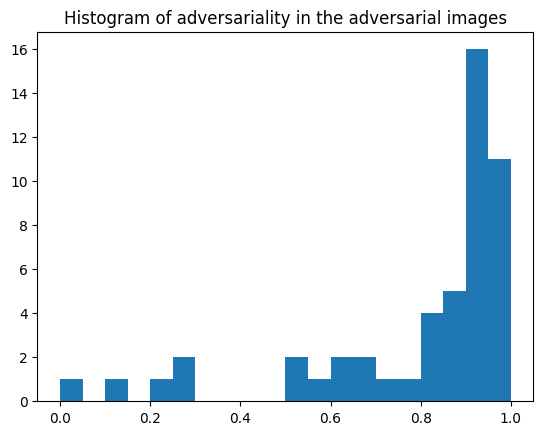

In [19]:
tfr_list = flatten_dict(adv_results, for_tfr=True)
plt.hist(tfr_list, bins=20)
plt.title("Histogram of adversariality in the adversarial images")
plt.show()